In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
image_folder_path = "./fruit-inspection-images"
images_first_task_path = os.path.join(image_folder_path, "first-task")
images_first_task = os.listdir(images_first_task_path)

ir_images = []
color_images = []

for img in images_first_task:
    if img[:2] == "C0":
        ir_images.append(img)
    else:
        color_images.append(img)

def load_image(image_number, ir = True):
    ir_image_path = os.path.join(images_first_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_first_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_GRAYSCALE if ir else cv2.IMREAD_COLOR)
    return image


In [3]:
def image_summary(image_path="", image=None, title=None, show_shape=False):
  if (image is None):
    image = cv2.imread(image_path)
  
  hist, bins = np.histogram(image.flatten(), 256, [0, 256])
  if (show_shape):
    print(image.shape)
 
  plt.figure(figsize=(10,5))  
  plt.subplot(1, 2, 1)
  if (title is not None):
    plt.title(title)
  plt.imshow(image, cmap="gray", vmin=0, vmax=255)
  plt.subplot(1, 2, 2)
  plt.stem(hist, use_line_collection=True)
  plt.tight_layout()
  plt.show()

In [4]:
def generate_threshold(image, display=True):
    ret, th = cv2.threshold(image.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if display:
        plt.imshow(th, cmap="gray", vmin=0, vmax=255)
        plt.title(ret)
        image_summary(image=image)
    return ret, th

In [5]:
# Floodfill to get the entire object
def generate_th_mask(th, display=True):
    th_copy = th.copy()
    h, w = th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(th_copy, mask, (0,0), 255)
    th_inv = cv2.bitwise_not(th_copy)
    th_mask = th | th_inv

    if display:
        plt.subplot(1, 2, 1)
        plt.imshow(th_inv, cmap="gray", vmin=0, vmax=255)
        plt.subplot(1, 2, 2)
        plt.imshow(th_mask, cmap="gray", vmin=0, vmax=255)


    return th_mask

In [6]:
# im_out is the binary mask for the fruit which we can use on the color image
# Apply the mask to the color image
def apply_mask(IMAGE_NUMBER, th_mask, display=True):
    color_image = load_image(IMAGE_NUMBER, ir=False)
    masked_image = cv2.bitwise_and(color_image, color_image, mask=th_mask)

    if (display):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 3, 2)
        plt.imshow(th_mask, cmap="gray", vmin=0, vmax=255)
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    
    return color_image, masked_image

In [7]:
# Apply sobel filter to the masked_image to detect the bad parts. Doesn't seem to work very good for our case.
def sobel_filter(image):
    horizontal_kernel = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
    ])

    vertical_kernel = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    dx = cv2.filter2D(image, -1, horizontal_kernel)
    dy = cv2.filter2D(image, -1, vertical_kernel)
    new_image = np.maximum(dx, dy)
    return new_image

In [8]:
# Input-image = BGR
def split_channels(image, display=True):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    lab_channels = cv2.split(lab)
    L = lab_channels[0]
    A = lab_channels[1]
    B = lab_channels[2]

    hsv_channels = cv2.split(hsv)
    H = hsv_channels[0]
    S = hsv_channels[1]
    V = hsv_channels[2]

    rgb_channels = cv2.split(rgb)
    R = rgb_channels[0]
    G = rgb_channels[1]
    Bl = rgb_channels[2]

    if display:
        plt.figure(figsize=(20, 10))

        plt.subplot(1, 10, 1)
        plt.title("H")
        plt.imshow(H)
        plt.subplot(1, 10, 2)
        plt.title("S")
        plt.imshow(S)
        plt.subplot(1, 10, 3)
        plt.title("V")
        plt.imshow(V)

        plt.subplot(1, 10, 4)
        plt.title("R")
        plt.imshow(R)
        plt.subplot(1, 10, 5)
        plt.title("G")
        plt.imshow(G)
        plt.subplot(1, 10, 6)
        plt.title("B")
        plt.imshow(B)

        plt.subplot(1, 10, 7)
        plt.title("L")
        plt.imshow(L)
        plt.subplot(1, 10, 8)
        plt.title("A")
        plt.imshow(A)
        plt.subplot(1, 10, 9)
        plt.title("Bl")
        plt.imshow(Bl)

        plt.subplot(1, 10, 10)
        plt.title("Gray")
        plt.imshow(gray, cmap="gray", vmin=0, vmax=255)

    return rgb, lab, hsv, L, A, B, H, S, V, R, G, Bl, gray

In [9]:

def mark_defects(image, ret, th_mask, display=True):
    LOWER = ret - 10
    UPPER = ret

    # The canny edge detector nicely outlines the defect fruit. Need to remove the initial edge to extract only the defect.
    blurred_channel = cv2.GaussianBlur(image, (3, 3), 0)
    # blurred_channel = cv2.bilateralFilter(image, 9, 150, 150)
    canny_image = cv2.Canny(blurred_channel, LOWER, UPPER)


    # Find the edge of the th_mask
    im_edge = cv2.Canny(th_mask, ret, ret)

    # Dilate the masked edge to better "hit" the edge when later bitwise-and'ing with the canny image
    im_edge = cv2.dilate(im_edge, np.ones((3,3)))
    im_edge_inv = cv2.bitwise_not(im_edge)

    # Bitwise and the masked image with the canny edge image to remove the edge and only show the defect
    image_without_border = cv2.bitwise_and(canny_image, im_edge_inv)

    defect_image = cv2.morphologyEx(image_without_border, cv2.MORPH_CLOSE, np.ones((3, 3)))
    defect_image = cv2.dilate(defect_image, np.ones((3, 3)))

    if display:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(canny_image, cmap="gray", vmin=0, vmax=255)
        plt.subplot(1, 2, 2)
        plt.imshow(defect_image, cmap="gray", vmin=0, vmax=255)
    
    return defect_image

In [10]:
def is_contour_bad(contour):
    # Check if the contour is too small
    if cv2.contourArea(contour) < 25:
        return True
    return False

def extract_contours(image, rgb_image, display=True):
    _, contours, _ = cv2.findContours(image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask to remove the contours that are too small
    mask = np.ones(image.shape[:2], dtype="uint8") * 255
    ellipses = []

    # Check if the contour is bad, if not add it to be drawn
    for contour in contours:
        if (is_contour_bad(contour)):
            cv2.drawContours(mask, [contour], -1, 0, -1)
        else:
            ellipses.append(cv2.fitEllipse(contour))

    # Remove the bad contours with the mask
    contours_image = cv2.bitwise_and(image, image, mask=mask)

    # Draw the ellipses on the original image
    for ellipse in ellipses:
        cv2.ellipse(contours_image, ellipse, (255,0,0), 50)

    if display:
        plt.figure(figsize=(16,8))
        plt.subplot(1,4,1)
        plt.imshow(image, cmap="gray", vmin=0, vmax=255)
        plt.subplot(1,4,2)
        plt.imshow(contours_image, cmap="gray", vmin=0, vmax=255)
        plt.subplot(1,4,3)
        plt.imshow(rgb_image)
        plt.subplot(1,4,4)
        display_defects(image, rgb_image)

    return contours_image


In [11]:
def display_defects(contours_image, rgb_image):
    alpha = 0.3
    beta = (1.0 - alpha)
    dst = cv2.addWeighted(cv2.cvtColor(contours_image, cv2.COLOR_GRAY2RGB), alpha, rgb_image, beta, 0.0)
    plt.imshow(dst, cmap="gray", vmin=0, vmax=255)


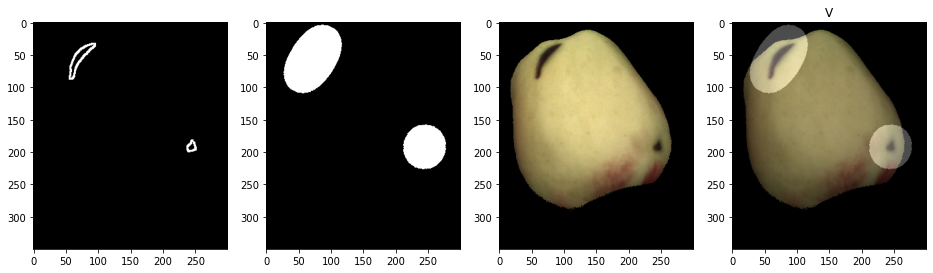

-------------------------------------------------------


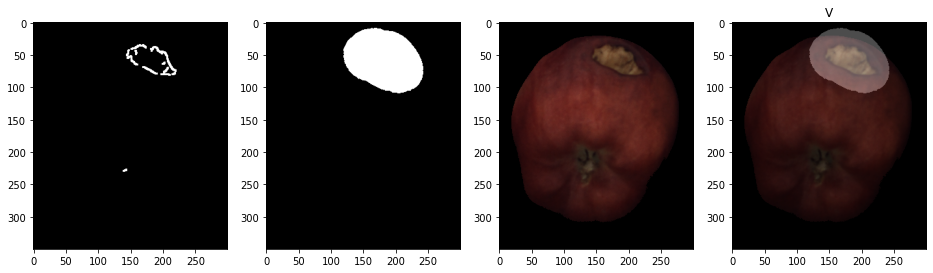

-------------------------------------------------------


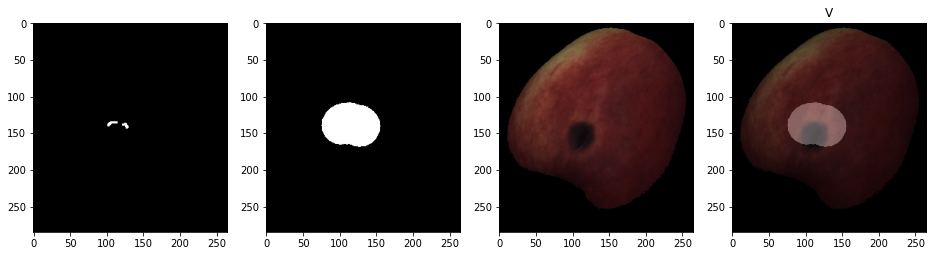

-------------------------------------------------------


In [12]:
def spot_defect(IMAGE_NUMBER):
    image = load_image(IMAGE_NUMBER, ir=True)
    ret, th = generate_threshold(image, display=False)
    th_mask = generate_th_mask(th, display=False)
    _, masked_image = apply_mask(IMAGE_NUMBER, th_mask, display=False)
    rgb, lab, hsv, L, A, B, H, S, V, R, G, Bl, gray = split_channels(masked_image, display=False)

    best_channels = {
        "V" : V,
    }
    
    for channel_name, channel in best_channels.items():
        defect_image = mark_defects(channel, ret, th_mask, display=False)
        contours_image = extract_contours(defect_image, rgb)
        display_defects(contours_image, rgb)
        plt.title(str(channel_name))
        plt.show()

    print("-------------------------------------------------------")
    
for i in range(3):
    spot_defect(i)